In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

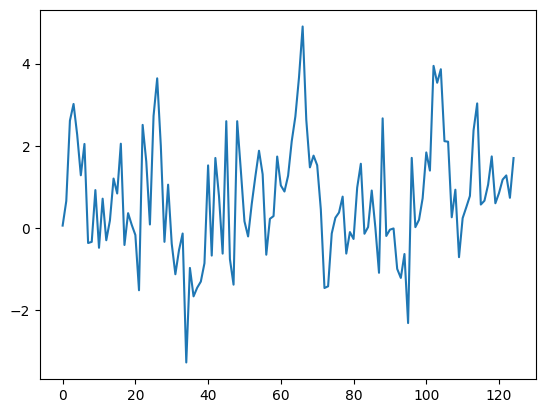

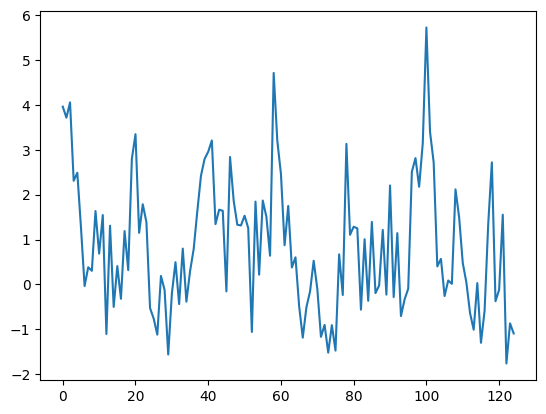

In [37]:
t = np.linspace(0, 250*10**(-3), 125)
f_s = 1/(t[1] - t[0])
x = np.zeros(125)
y = np.zeros(125)
x += np.sin(2*np.pi*t) + np.sin(20*np.pi*t) + np.sin(50*np.pi*t) + np.sin(80*np.pi*t)
x += np.random.normal(0, 1, 125)
y += np.cos(2*np.pi*t) + np.cos(20*np.pi*t) + np.cos(50*np.pi*t) + np.cos(100*np.pi*t)
y += np.random.normal(0, 1, 125)
plt.plot(x)
plt.show()
plt.plot(y)
plt.show()

In [4]:
def crossSpectrum_Welsh(x, y, nperseg=500, overlap=250, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = None, f=None):

    if f_sample is not None and f is not None:
        l = f * nperseg / f_sample
    D = nperseg - overlap
    L = nperseg
    N = len(x)
    if padding and (N - L) % D != 0:
        # Zero padding
        overflow = ((N-L)//D+1)*D + L - N
        x = np.append(x, np.zeros(overflow))
        y = np.append(y, np.zeros(overflow))

    cross = []
    ind = 0
    K = 0

    if window == 'hann':
        window = signal.windows.hann(L)
    elif window == 'hamming':
        window = signal.windows.hamming(L)
    elif window == 'blackman':
        window = signal.windows.blackman(L)
    else:
        window = signal.windows.boxcar(L)

    U = np.sum(window**2) / L
    
    while ind + L <= len(x):

        xp = x[ind : ind + L] 
        yp = y[ind : ind + L] 
        xp = sc.signal.detrend(xp, type='constant')
        yp = sc.signal.detrend(yp, type='constant')

        # Do FFT
        if mode == "scipy":
            cfx = sc.fft.fft(xp * window / L)
            cfy = sc.fft.fft(yp * window / L)
        if mode == "manual":
            exp_vector = np.exp(-2j * np.pi * np.arange(L) * l / L)
            cfx = np.dot(xp * window / L, exp_vector)
            cfy = np.dot(yp * window / L, exp_vector)

        # Get cross spectrum
        cross.append(cfx.conj()*cfy)

        ind += D
        K += 1
    
    cross = np.array(cross) 

    if aggregate == "mean":
        cross = np.mean(cross, axis=0)
    elif aggregate == "median":
        cross = np.median(cross, axis=0)
    elif aggregate == "max":
        cross = np.max(cross, axis=0)
    
    return cross

Coefficients: [0.25374302 0.25059021 0.2009481  0.20620806]


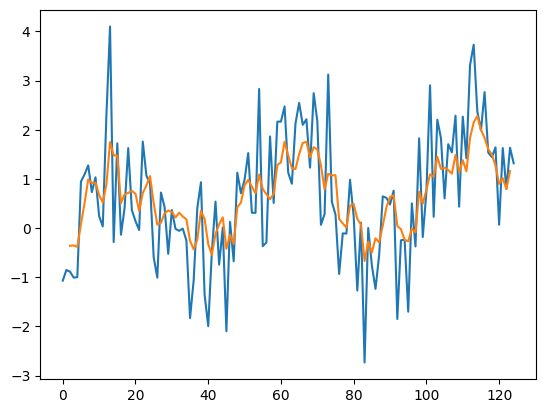

In [22]:
# AR model
model = AutoReg(x, lags=3)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
x_pred = model_fit.predict(start=1, end=124)
plt.plot(x)
plt.plot(x_pred)
plt.show()

In [19]:
1500 - 700 + 125 - 200

725

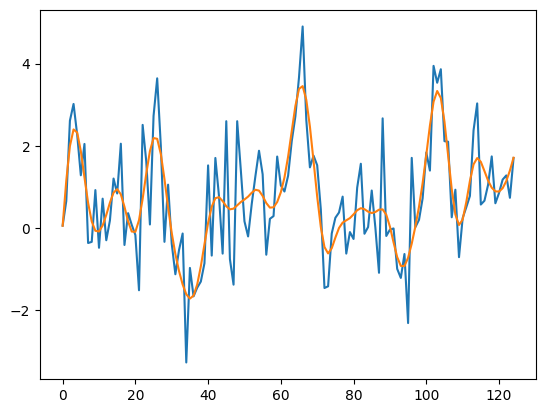

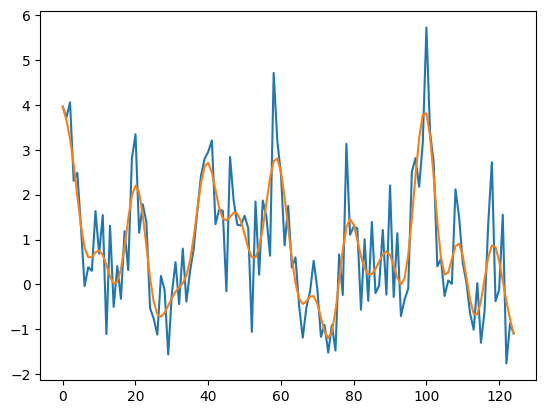

In [38]:
# low pass filter
low_pass = signal.butter(3, 60, "low", fs=500)
x_low_pass_filter = signal.filtfilt(*low_pass, x)
y_low_pass_filter = signal.filtfilt(*low_pass, y)
plt.plot(x)
plt.plot(x_low_pass_filter)
plt.show()
plt.plot(y)
plt.plot(y_low_pass_filter)
plt.show()

[31 40 10  8  4  6  3  1  2  5]


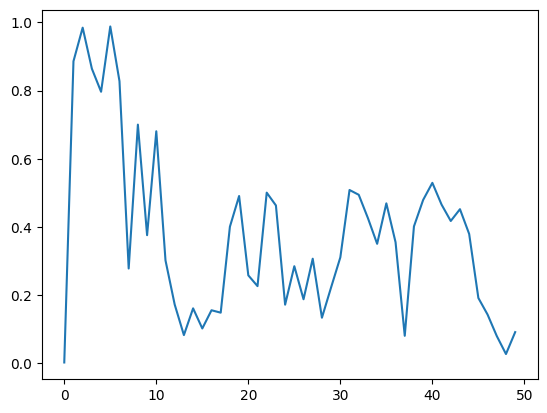

In [44]:
nperseg = 100
noverlap = 25
Pxy = crossSpectrum_Welsh(x, y, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = f_s, f=5)

Pxx = crossSpectrum_Welsh(x, x, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode="scipy", f_sample = f_s, f=5)

Pyy = crossSpectrum_Welsh(y, y, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode="scipy", f_sample = f_s, f=5)

coh = np.abs(Pxy)/np.sqrt(np.abs(Pxx)*np.abs(Pyy)+1e-4)
plt.plot(coh[:len(coh)//2])
print(np.argsort(coh[:len(coh)//2])[-10:])

[ 7  9 10  8  4  6  3  1  2  5]


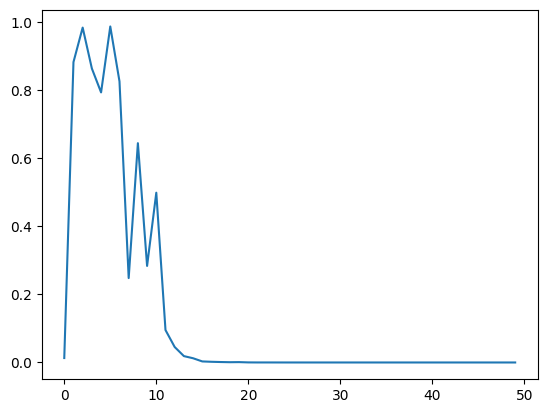

In [46]:
nperseg = 100
noverlap = 25
Pxy = crossSpectrum_Welsh(x_low_pass_filter, y_low_pass_filter, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode = "scipy", f_sample = f_s, f=5)

Pxx = crossSpectrum_Welsh(x_low_pass_filter, x_low_pass_filter, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode="scipy", f_sample = f_s, f=5)

Pyy = crossSpectrum_Welsh(y_low_pass_filter, y_low_pass_filter, nperseg=nperseg, overlap=noverlap, window='hann', padding = False, aggregate='mean', mode="scipy", f_sample = f_s, f=5)

coh = np.abs(Pxy)/np.sqrt(np.abs(Pxx)*np.abs(Pyy)+1e-4)
plt.plot(coh[:len(coh)//2])
print(np.argsort(coh[:len(coh)//2])[-10:])

In [57]:
10 / 100 * 500

50.0